## Collective memory

### Aims:
- Statistic frequency distribution of collective memory in each major historical ﬂood.
- Exploring different distribution of collective memory when grouped by other fields.
- Fitting decay rate by different model

#### Mission 1: Frequency distribution

In [1]:
import pandas as pd
import numpy as np
import json
from matplotlib import pyplot as plt
from lmfit import Parameters, Minimizer, report_fit

from data_process import *
from collective_memory import judge_damage
from model_test import fit_nash, goodness_of_fit, adjusted_goodness

#### Parameters of fitting

In [2]:
fit_result = pd.DataFrame(columns=['data', 'vary', 'bound', 'x_col', 'y_col', 'params', 'nash', 'r2', 'adj_r2'])

In [13]:
KIND = 'off-farm'
VARY = True
BOUND = False

# 数据

In [14]:
index = list(MAJOR_HISTORICAL_FLOODS) + [2018]
flood = pd.DataFrame(index=index)

datasets = {}
datasets['all'] = questionnaires
datasets['farm'] = questionnaires[questionnaires['farm']]
datasets['off-farm'] = questionnaires[questionnaires['farm'] == False]

data = datasets[KIND]

for y in MAJOR_HISTORICAL_FLOODS:
    flood.loc[y, 'relative_level'] = major_floods['flood_level'].loc[y] - W_MIN
    flood.loc[y, 'exceeding_level'] = major_floods.loc[y, 'flood_level'] - get_actual_levee_height(y)
    flood.loc[y, 'damage'] = judge_damage(major_floods.loc[y, 'flood_level'], get_actual_levee_height(y))
    flood.loc[y, 'pop'] = estimated_population[y] * flood.loc[y, 'damage']
flood.loc[2018, :] = np.zeros(len(flood.columns))

memory = stats_fre_questionnaris(data, MAJOR_HISTORICAL_FLOODS, normalize=True)
memory['sum'] = memory['communicative'] + memory['cultural']
flood
memory

def nomarlization(x):
    return (x - x.min())/ (x.max() - x.min())

,relative_level,exceeding_level,damage,pop
1904,6.2,6.20,0.070746,3760.808418
1946,4.1,4.10,0.047362,11894.531006
1964,3.4,3.40,0.039438,19267.592189
1981,3.6,3.60,0.041709,38201.868482
2012,2.3,0.26,0.003072,8851.711757
2018,0.0,0.00,0.000000,0.000000


,communicative,cultural,collective,sum
1904,0.247093,0.177326,0.386628,0.424419
1946,0.258721,0.177326,0.383721,0.436047
1964,0.287791,0.177326,0.409884,0.465116
1981,0.363372,0.168605,0.476744,0.531977
2012,0.351744,0.244186,0.523256,0.595930


# 指数衰减拟合

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 5
    # variables        = 2
    chi-square         = 0.00454489
    reduced chi-square = 0.00151496
    Akaike info crit   = -31.0159511
    Bayesian info crit = -31.7970752
[[Variables]]
    n:  1.40382398 +/- 0.09696938 (6.91%) (init = 0.5)
    k:  0.01189163 +/- 0.00116626 (9.81%) (init = 0.015)
[[Correlations]] (unreported correlations are < 0.100)
    C(n, k) =  0.818
nash is 0.690, r^2 is 0.690, adjusted r2 is 0.587.


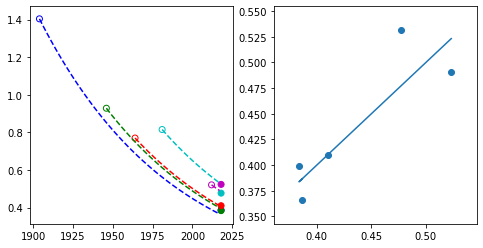

Successfully stored "miu_s" parameter as a json file.


In [15]:
# Fitting
def fit_exp_decay(flood_col, memory_col, bounder=False, vary=True):
    x_data = flood[flood_col]
    y_data = memory[memory_col]
    
    def exp_decay(t1, t0, n0, k):
        return n0 * np.exp(-k * (t1 - t0))

    def residual(params, x_data, y_data):
        n0, k = params['n'], params['k']
        influence = n0 * nomarlization(x_data)
        y_model = []
        for year in MAJOR_HISTORICAL_FLOODS:
            y_model.append(exp_decay(t1=SERVEY_YEAR, t0=year, n0=influence[year], k=k))
        return np.array(y_model) - y_data

    fit_params = Parameters()
    if bounder:
        fit_params.add(name='n', value=1, min=0, max=1)
    else:
        fit_params.add(name='n', value=0.5, min=0, vary=vary)
    fit_params.add(name='k', value=0.015, min=0)
    minner = Minimizer(residual, fit_params, fcn_args=[x_data, y_data])
    result = minner.minimize()
    report_fit(result)

    # plotting
    t_arr = np.arange(1900, 2020)

    colors = ['b', 'g', 'r', 'c', 'm']
    k, n0 = [result.params[key].value for key in ['k', 'n']]
    influence = n0 * nomarlization(x_data).loc[MAJOR_HISTORICAL_FLOODS]
    y_model = []
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    
    ax1.scatter(x=influence.index, y=influence.values, color='w', edgecolors=colors)
    ax1.scatter(x=[SERVEY_YEAR] * 5, y=y_data, color=colors)

    for i in range(len(MAJOR_HISTORICAL_FLOODS)):
        start_year = MAJOR_HISTORICAL_FLOODS[i]
        t_slices = np.arange(start_year, SERVEY_YEAR)
        y_func = exp_decay(t_slices, start_year, influence[start_year], k)
        ax1.plot(t_slices, y_func, '--', c=colors[i])
        y_model.append(y_func[-1])
    
    nash = fit_nash(y_data, y_model)
    r2 = goodness_of_fit(y_data, y_model)
    adj_r2 = adjusted_goodness(y_data, y_model)
    print("nash is {:.3f}, r^2 is {:.3f}, adjusted r2 is {:.3f}.".format(nash, r2, adj_r2))
    
    ax2.scatter(y_data, y_model, label='forecast by model')
    ax2.plot(y_data, y_data, label='1:1 line')
    plt.show()
    
    re = {
        'data': KIND,
        'vary': vary,
        'bound': bounder,
        'x_col': flood_col,
        'y_col': memory_col,
        'params': "n = {:.3f}, k = {:.3f}".format(n0, k),
        'nash': "{:.3f}".format(nash),
        'r2': "{:.3f}".format(r2),
        'adj_r2': "{:.3f}".format(adj_r2)
    }
    return k, re

miu_s, setting =  fit_exp_decay('relative_level', 'collective', bounder=BOUND, vary=VARY)
fit_result = fit_result.append(setting, ignore_index=True)

with open('data/miu_s.json', 'w') as f:
    json.dump(miu_s, f)
print('Successfully stored "miu_s" parameter as a json file.')

# Universal decay model 拟合

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 261
    # data points      = 15
    # variables        = 4
    chi-square         = 0.01189493
    reduced chi-square = 0.00108136
    Akaike info crit   = -99.0954020
    Bayesian info crit = -96.2632012
[[Variables]]
    n:  0.99309392 +/- 0.05631165 (5.67%) (init = 1)
    p: -0.59708090 +/- 5.89428805 (987.18%) (init = 0.05)
    r:  0.60929663 +/- 5.89376910 (967.31%) (init = 0.03)
    q:  0.99999989 +/- 48.4111552 (4841.12%) (init = 0.05)
[[Correlations]] (unreported correlations are < 0.100)
    C(p, r) = -1.000
    C(r, q) = -1.000
    C(p, q) =  1.000
    C(n, p) =  0.405
    C(n, r) = -0.405
    C(n, q) =  0.400


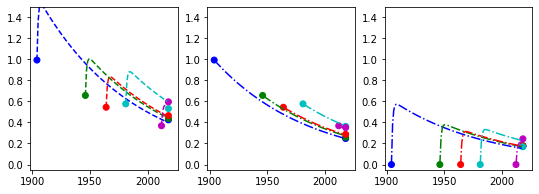

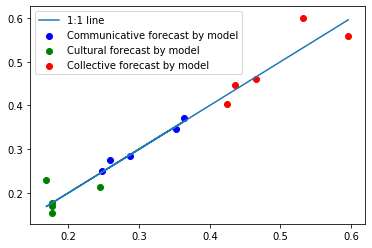

nash is 0.954, r^2 is 0.954, adjusted r2 is 0.951.
Successfully stored "p, q, and r" parameters as a json file.


In [16]:
def fit_prq_decay(flood_col, memory_col, bounder=False, vary=True):
    years = MAJOR_HISTORICAL_FLOODS
    x_data = flood[flood_col]
    u_data = list(memory['communicative'].values)
    v_data = list(memory['cultural'].values)
    m_data = list(memory[memory_col].values)
    y_data = np.array(u_data + v_data + m_data)
    
    # Fitting
    def ut(t, n, p, r):
        return n * np.exp(-(p + r) * t)

    def vt(t, n, p, r, q):
        return (n * r / (p + r - q)) * (np.exp((-q) * t) - np.e ** (-(p + r) * t))

    def mt(t, n, p, r, q):
        return (n / (p + r - q)) * ((p - q) * np.exp(-(p + r) * t) + r * np.exp(-q * t))

    def residuals(params, x_data, y_data):
        n0, p, r, q = params['n'], params['p'], params['r'], params['q']
        influence = n0 * nomarlization(x_data)
        u_list, v_list, m_list = [], [], []
        for y in MAJOR_HISTORICAL_FLOODS:
            t = SERVEY_YEAR - y
            n = influence[y]
            m_list.append(mt(t, n, p, r, q))
            u_list.append(ut(t, n, p, r))
            v_list.append(vt(t, n, p, r, q))
        y_model = np.array(u_list + v_list + m_list)
        return y_data - y_model

    fit_params = Parameters()
    if bounder:
        fit_params.add(name='n', value=1, min=0, max=1, vary=vary)
    else:
        fit_params.add(name='n', value=1, min=0, vary=vary)
    fit_params.add(name="p", value=0.05, max=1)
    fit_params.add(name="r", value=0.03, min=0, max=1)
    fit_params.add(name="q", value=0.05, min=0, max=1)

    minner = Minimizer(residuals, fit_params, fcn_args=[x_data, y_data])
    result = minner.minimize()
    report_fit(result)

    # plotting
    t_arr = np.arange(1900, 2020)
    colors = ['b', 'g', 'r', 'c', 'm']
    n0, p, q, r = [result.params[key].value for key in ['n', 'p', 'q', 'r']]
    influence = n0 * nomarlization(x_data).loc[MAJOR_HISTORICAL_FLOODS]
    u_list, v_list, m_list = [], [], []
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
    ax1.scatter(x=influence.index, y=influence.values, color=colors, marker='o')
    ax1.scatter(x=[SERVEY_YEAR] * 5, y=memory[memory_col], color=colors)
    
    ax2.scatter(x=influence.index, y=influence.values, color=colors, marker='o')
    ax2.scatter(x=[SERVEY_YEAR] * 5, y=memory['communicative'], color=colors)
    
    ax3.scatter(x=influence.index, y=[0] *5, color=colors, marker='o')
    ax3.scatter(x=[SERVEY_YEAR] * 5, y=memory['cultural'], color=colors)

    for i in range(len(MAJOR_HISTORICAL_FLOODS)):
        start_year = MAJOR_HISTORICAL_FLOODS[i]
        t_slices = np.arange(start_year, SERVEY_YEAR)
        u_model = ut(t_slices-start_year, influence[start_year], p, r)
        v_model = vt(t_slices-start_year, influence[start_year], p, r, q)
        m_model = mt(t_slices-start_year, influence[start_year], p, r, q)
        u_list.append(u_model[-1])
        v_list.append(v_model[-1])
        m_list.append(m_model[-1])
        ax1.plot(t_slices, m_model, '--', c=colors[i])
        ax2.plot(t_slices, u_model, '-.', c=colors[i])
        ax3.plot(t_slices, v_model, '-.', c=colors[i])
    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(-0.05, 1.5)
    plt.show()
    
    y_model = np.array(u_list + v_list + m_list)
    r2 = goodness_of_fit(y_data, y_model)
    nash = fit_nash(y_data, y_model)
    adj_r2 = adjusted_goodness(y_data, y_model)


    plt.scatter(u_data, u_list, label='Communicative forecast by model', c='b')
    plt.scatter(v_data, v_list, label='Cultural forecast by model', c='g')
    plt.scatter(m_data, m_list, label='Collective forecast by model', c='r')
    plt.plot(y_data, y_data, label='1:1 line')
    plt.legend()
    plt.show()
    print("nash is {:.3f}, r^2 is {:.3f}, adjusted r2 is {:.3f}.".format(nash, r2, adj_r2))
    
    re = {
        'data': KIND,
        'vary': vary,
        'bound': bounder,
        'x_col': flood_col,
        'y_col': memory_col,
        'params': "n = {:.3f}, p = {:.3f}, r = {:.3f}, q = {:.3f}".format(n0, p, r, q),
        'nash': "{:.3f}".format(nash),
        'r2': "{:.3f}".format(r2),
        'adj_r2': "{:.3f}".format(adj_r2)
    }
    
    return (p, r, q), re


params, setting = fit_prq_decay('relative_level', 'sum', bounder=BOUND, vary=VARY)
fit_result = fit_result.append(setting, ignore_index=True)

p, r, q = params
pqr_dic = {
    'p': p,
    'q': q,
    'r': r
}
with open('data/pqr_dic.json', 'w') as f:
    json.dump(pqr_dic, f)
print('Successfully stored "p, q, and r" parameters as a json file.')



In [17]:
fit_result

,data,vary,bound,x_col,y_col,params,nash,r2,adj_r2
0,all,True,False,relative_level,collective,"n = 1.534, k = 0.016",0.936,0.936,0.914
1,all,True,False,relative_level,sum,"n = 1.133, p = -0.470, r = 0.487, q = 1.000",0.968,0.968,0.965
2,farm,True,False,relative_level,collective,"n = 1.707, k = 0.022",0.807,0.807,0.743
3,farm,True,False,relative_level,sum,"n = 1.432, p = -0.042, r = 0.067, q = 0.196",0.910,0.910,0.903
4,off-farm,True,False,relative_level,collective,"n = 1.404, k = 0.012",0.690,0.690,0.587
5,off-farm,True,False,relative_level,sum,"n = 0.993, p = -0.597, r = 0.609, q = 1.000",0.954,0.954,0.951
